<a href="https://colab.research.google.com/github/imshivs/congressional-analysis/blob/master/Congressional_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kriti Saxena (krsaxena@calpoly.edu) 

Shivani Negi (shnegi@calpoly.edu)



# Introduction

As seen in the intro class congressional analysis, there is a relationship between income and party affiliations. We believe that education acts a confounder variable between the two variables. We will analyze if education acts as a mediator variable


# Hypothesis 

We believe education is a mediator variable that explains the relationship between income and party affiliation. This is our assumption because in every day life, education seems to be an important component in hiring, and therefore it has a direct relationship to how much one earns. We conducted an exploratory analysis in three steps to test whether education explains the process through which income and party affiliation are perhaps related.

# Data Collection & Cleaning

It should be noted that each person in the census' education dataset is regionally placed based on each surveyee's place of birth, not their residence at the time the data was collected. While we're not sure exactly why the data was formatted or collected this way, we have a theory. Residency in the US may be difficult to determine. Whether they've moved just across the street or all the way across the country, US residents are supposed to update their address with the DMV (in addition to updating their driver's license and car registration), but not everyone follows these rules punctually. Many people move frequently and it has become more popular to live a nomadic lifestyle. Moreover, there are cost barriers to getting a new driver's license and DMV fees/insurance rates are more expensive in some states compared to others.

Read more: https://moving.tips/bonus-tips-and-tricks/updating-drivers-license-after-moving/

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd 
import statistics
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import warnings

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

In [ ]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B01003_001E,B06009_001E,B06009_002E,B06009_004E,B06009_005E,B06009_006E,B19001_017E,B19001_001E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: n. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Population','total place of birth','less than high school', 'high school', 'some college', 'bachelors degree','graduate or professional degree','Total Households', '$200k+', 'State code','district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['District Name','Population','total place of birth','less than high school', 'high school', 'some college', 'bachelors degree','graduate or professional degree','Total Households', '$200k+', 'district number', 'State']]


In [ ]:
# converting columns to numeric
acs_df["Population"] = pd.to_numeric(acs_df["Population"])
acs_df["total place of birth"] = pd.to_numeric(acs_df["total place of birth"])
acs_df["less than high school"] = pd.to_numeric(acs_df["less than high school"])
acs_df["high school"] = pd.to_numeric(acs_df["high school"])
acs_df["some college"] = pd.to_numeric(acs_df["some college"])
acs_df["bachelors degree"] = pd.to_numeric(acs_df["bachelors degree"])
acs_df["graduate or professional degree"] = pd.to_numeric(acs_df["graduate or professional degree"])
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
#acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

In [ ]:
# Data Wrangling 
acs_df['No college'] = acs_df['less than high school'] + acs_df['high school'] #+ acs_df["some college"]
acs_df['Bachelors or higher'] = acs_df['bachelors degree'] + acs_df['graduate or professional degree']
#acs_df['Graduate or professional'] = acs_df["graduate or professional degree"]  

In [ ]:
# Converting to percentages
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% place of birth no college'] = (100*acs_df['No college'])/acs_df['total place of birth']
#acs_df['% of population bachelors'] = (100*acs_df['Bachelors'])/acs_df['Population']
acs_df['% place of birth bachelors'] = (100*acs_df["bachelors degree"])/acs_df['total place of birth']
acs_df['% place of birth graduate or professional degree'] = (100*acs_df["graduate or professional degree"])/acs_df['total place of birth']
acs_df['% place of birth some college'] = (100*acs_df["some college"])/acs_df['total place of birth']
acs_df['% place of birth bachelors or higher'] = acs_df['% place of birth graduate or professional degree'] + acs_df['% place of birth bachelors'] + acs_df['% place of birth some college']

In [ ]:
acs_df

,District Name,Population,total place of birth,less than high school,high school,some college,bachelors degree,graduate or professional degree,Total Households,$200k+,district number,State,No college,Bachelors or higher,% of households over $200k,% place of birth no college,% place of birth bachelors,% place of birth graduate or professional degree,% place of birth some college,% place of birth bachelors or higher
0,"Congressional District 1 (116th Congress), Ala...",735373,510408.0,54098.0,157093.0,77910.0,51903.0,12033,287768,12033,1,Alabama,211191.0,63936.0,4.181493,41.376898,10.168924,2.357526,15.264259,27.790709
1,"Congressional District 2 (116th Congress), Ala...",690107,470899.0,60981.0,136973.0,66607.0,42900.0,10659,267988,10659,2,Alabama,197954.0,53559.0,3.977417,42.037465,9.110234,2.263543,14.144647,25.518423
2,"Congressional District 3 (116th Congress), Ala...",742147,500335.0,68610.0,153671.0,75017.0,51333.0,9731,285773,9731,3,Alabama,222281.0,61064.0,3.405150,44.426434,10.259726,1.944897,14.993354,27.197977
3,"Congressional District 4 (116th Congress), Ala...",708532,488670.0,74528.0,146738.0,57904.0,37341.0,10066,265042,10066,4,Alabama,221266.0,47407.0,3.797889,45.279227,7.641353,2.059877,11.849305,21.550535
4,"Congressional District 5 (116th Congress), Ala...",773212,537863.0,59160.0,151691.0,116268.0,76993.0,24457,312227,24457,5,Alabama,210851.0,101450.0,7.833083,39.201618,14.314612,4.547069,21.616657,40.478337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,"Congressional District 6 (116th Congress), Wis...",727054,514498.0,32795.0,163918.0,97035.0,47009.0,17590,303251,17590,6,Wisconsin,196713.0,64599.0,5.800476,38.233968,9.136867,3.418867,18.860132,31.415866
433,"Congressional District 7 (116th Congress), Wis...",739235,534723.0,34963.0,181676.0,91008.0,44499.0,16713,313108,16713,7,Wisconsin,216639.0,61212.0,5.337775,40.514248,8.321879,3.125544,17.019653,28.467075
434,"Congressional District 8 (116th Congress), Wis...",753174,526136.0,34490.0,160366.0,110675.0,44955.0,17638,311259,17638,8,Wisconsin,194856.0,62593.0,5.666663,37.035291,8.544369,3.352365,21.035436,32.932170
435,Congressional District (at Large) (116th Congr...,578803,395348.0,25356.0,146560.0,73255.0,42363.0,14179,242763,14179,0,Wyoming,171916.0,56542.0,5.840676,43.484727,10.715370,3.586461,18.529245,32.831075


In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]


**The averages for each level of educational attainment percentages added together equal 99.81%. The Census may be missing education data for a very small percentage of US residents.**

In [44]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])
final_merged_df = merged_df[['% place of birth no college','% place of birth some college','% place of birth bachelors or higher', 'Party', '% of households over $200k']]
final_merged_df.loc['Average'] = final_merged_df.mean(numeric_only=True)
final_merged_df

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,% place of birth no college,% place of birth some college,% place of birth bachelors or higher,Party,% of households over $200k
0,41.376898,15.264259,27.790709,R,4.181493
1,42.037465,14.144647,25.518423,R,3.977417
2,44.426434,14.993354,27.197977,R,3.405150
3,45.279227,11.849305,21.550535,R,3.797889
4,39.201618,21.616657,40.478337,R,7.833083
...,...,...,...,...,...
431,38.233968,18.860132,31.415866,R,5.800476
432,40.514248,17.019653,28.467075,R,5.337775
433,37.035291,21.035436,32.932170,R,5.666663
434,43.484727,18.529245,32.831075,R,5.840676


# Part 1: The Relationship between Education and Party Affiliation

In part one of our testing, we look at relationship between education and party affiliations, based on this density plot of population without college degree, both the plots are slightly skewed. The percentage of population without any college degree is more concentrated in republican districts which is centered around approximately 40%. On the other hand, the percentage of population with bachelor’s degree is more concentrated in democratic districts with approximately 20%. Lastly, for graduate and professional degree, both the plots are skewed to left but the percentage of population is more concentrated in democratic districts with the percentages being little over 4%. 


In [ ]:
colors = {'R': '#FF0000', 'D': '#0015BC', 'L': '#FFFF00'}

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Plot % of population born in each district with no college degree')

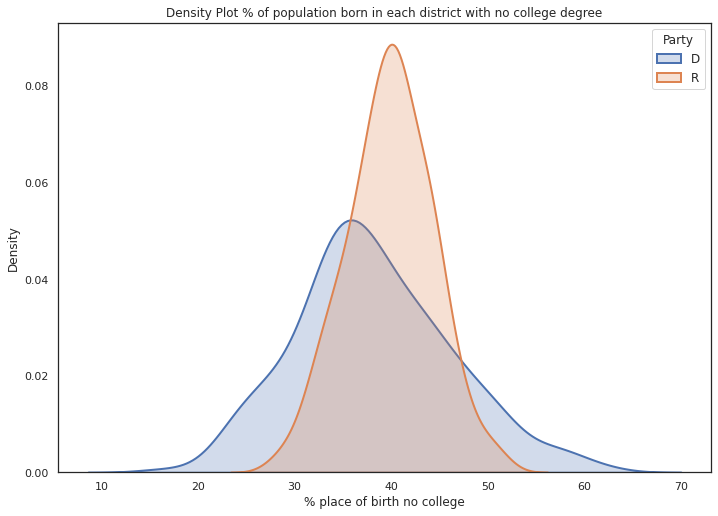

In [ ]:
# List of Party
Party = ['D', 'R']

# Iterate through Party
for Party in Party:
    # Subset
    subset = final_merged_df[final_merged_df['Party'] == Party]
    
    # Draw the density plot
    sns.distplot(subset['% place of birth no college'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = Party)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Party')
plt.title('Density Plot % of population born in each district with no college degree')

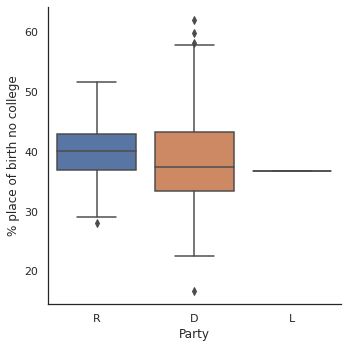

In [ ]:
sns.catplot(data= final_merged_df, x="Party", y="% place of birth no college", kind="box")

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


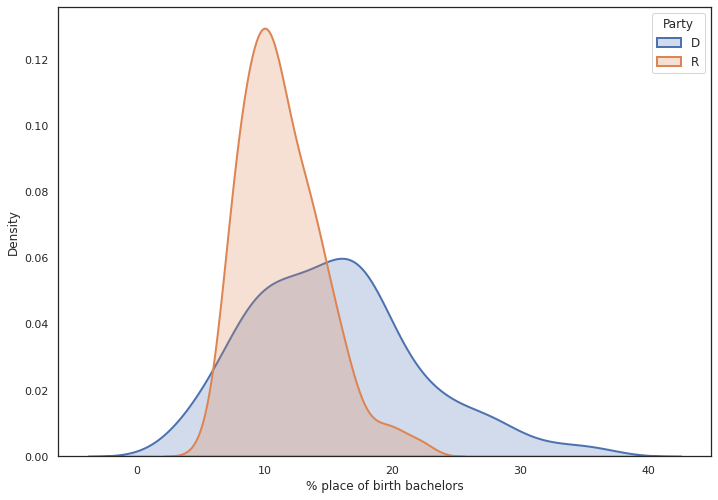

In [ ]:
Party = ['D', 'R']

# Iterate through the party
for Party in Party:
    # Subset 
    subset = final_merged_df[final_merged_df['Party'] == Party]
    
    # Draw the density plot
    sns.distplot(subset['% place of birth bachelors'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = Party)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Party')


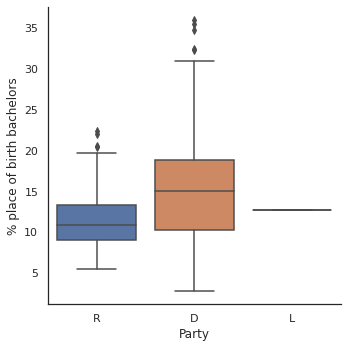

In [ ]:
sns.catplot(data= final_merged_df, x="Party", y="% place of birth bachelors", kind="box")

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


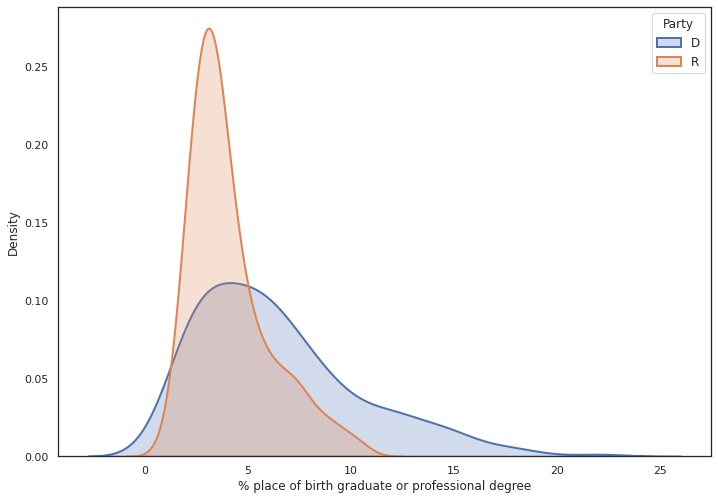

In [ ]:
Party = ['D', 'R']

# Iterate through Party
for Party in Party:
    # Subset 
    subset = final_merged_df[final_merged_df['Party'] == Party]
    
    # Draw the density plot
    sns.distplot(subset['% place of birth graduate or professional degree'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = Party)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Party')


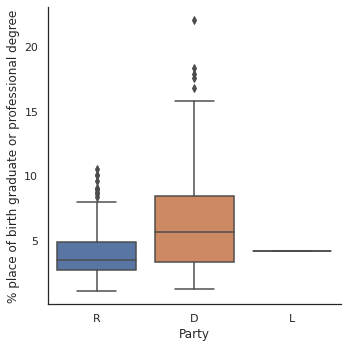

In [ ]:
sns.catplot(data= final_merged_df, x="Party", y="% place of birth graduate or professional degree", kind="box")

# Part 2: The Relationship between Income and Education

The scatter plot belows shows a positive correlation between the proporation of the US population with a college education and the proportion of households earning 200K dollars or higher. We also see that in highly education districts where 20% or more households make over $200K, elected officials tend to be democrats. The second scatterplot shows a negative correlation between the proportion of the US population that never attended college vs the prorportion of households earning 200K dollars or higher.


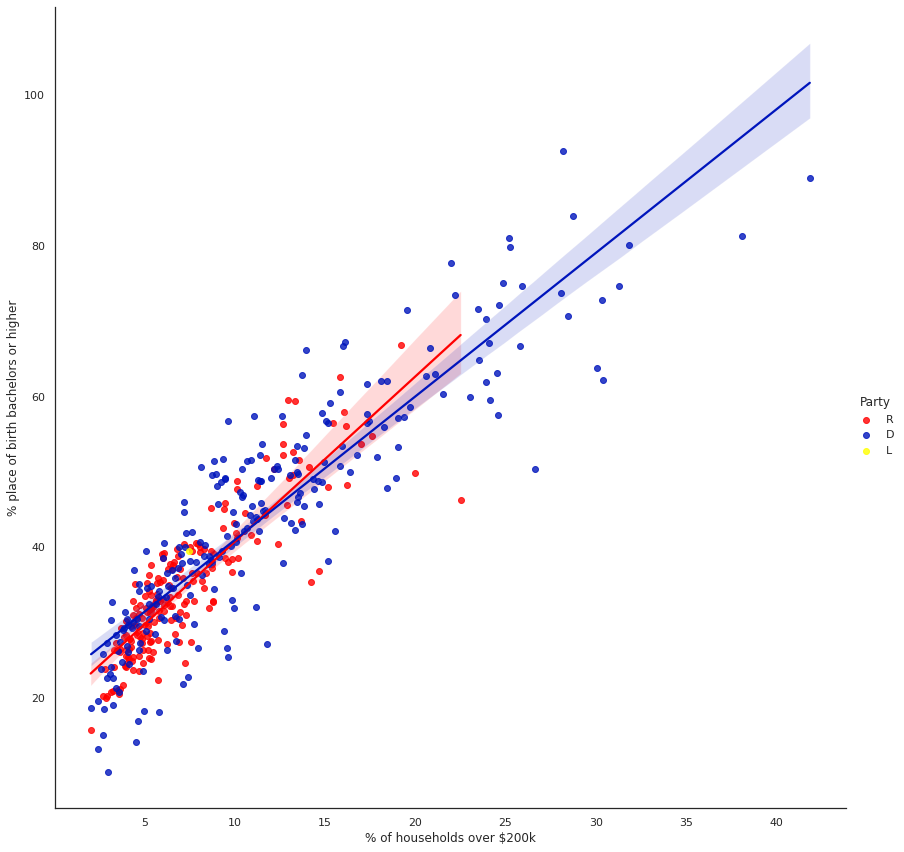

In [ ]:
R = merged_df.where((merged_df['Party'].str.contains('R')))
D = merged_df.where((merged_df['Party'].str.contains('D'))) 

sns.lmplot(x="% of households over $200k", y="% place of birth bachelors or higher", hue = 'Party', data=final_merged_df, palette = colors, height=12);
rcParams['figure.figsize'] = 15,8.27


**Pearson's Coefficient - Republicans (Bachelors or Higher vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% place of birth bachelors or higher', '% of households over $200k']]
R_1 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_1 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_1.corr(method="pearson")

,% place of birth bachelors or higher,% of households over $200k
% place of birth bachelors or higher,1.000000,0.869967
% of households over $200k,0.869967,1.000000


**Pearson's Coefficient - Democrats (Bachelors or Higher vs. Households over $200k)**

In [ ]:
D_1.corr(method="pearson")

,% place of birth bachelors or higher,% of households over $200k
% place of birth bachelors or higher,1.000000,0.892093
% of households over $200k,0.892093,1.000000


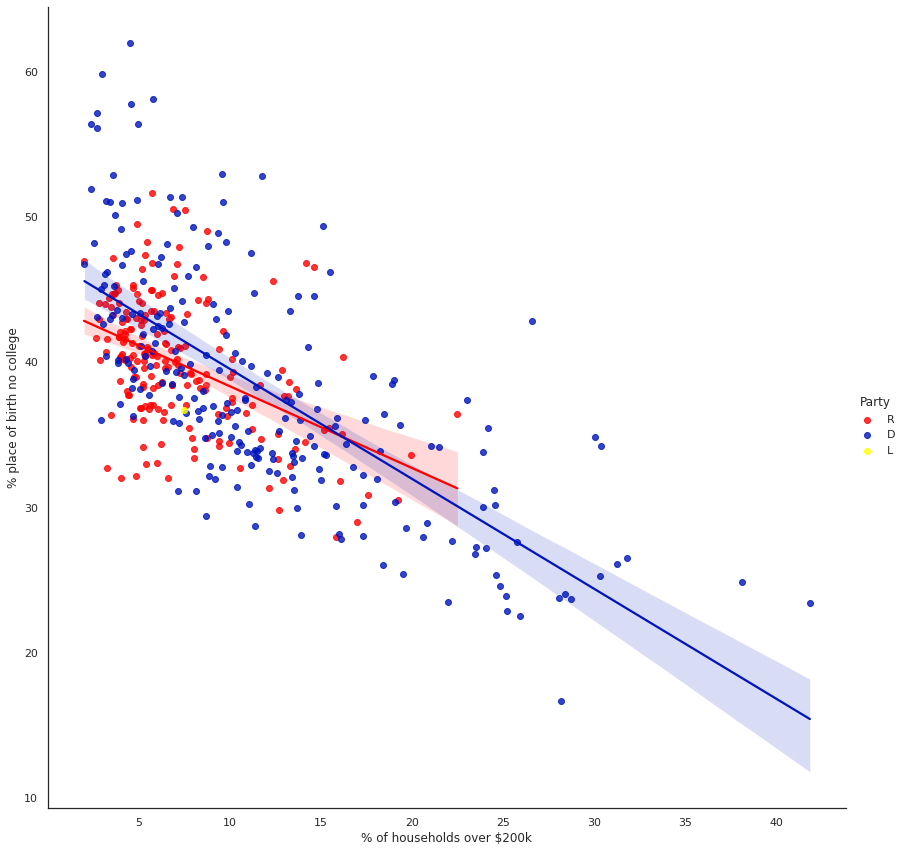

In [ ]:
sns.lmplot(x="% of households over $200k", y="% place of birth no college", hue = 'Party', data=final_merged_df, palette = colors, height=12);
rcParams['figure.figsize'] = 15,8.27

**Pearson's Coefficient - Republicans (No Education vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% place of birth no college', '% of households over $200k']]
R_2 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_2 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_2.corr(method="pearson")

,% place of birth no college,% of households over $200k
% place of birth no college,1.000000,-0.468344
% of households over $200k,-0.468344,1.000000


**Pearson's Coefficient - Democrats (No Education vs. Households over $200k)**

In [ ]:
D_2.corr(method="pearson")

,% place of birth no college,% of households over $200k
% place of birth no college,1.00000,-0.70313
% of households over $200k,-0.70313,1.00000


# Part 3: Plotting Varying Levels of Education vs Income

The follower scatterplots show varying levels of education vs % of households earning over 200K dollars. There seems to be positive correlation between income and education in all three cases. The relationship seems to be the strongest in the first scatterplot, where the correlation between % of population with a graduate or professional degree and % of population earning over 200K dollars is nearly 1. 1 indicates a perfectly positive linear correlation and -1 indicates a perfectly negative linear correlation.


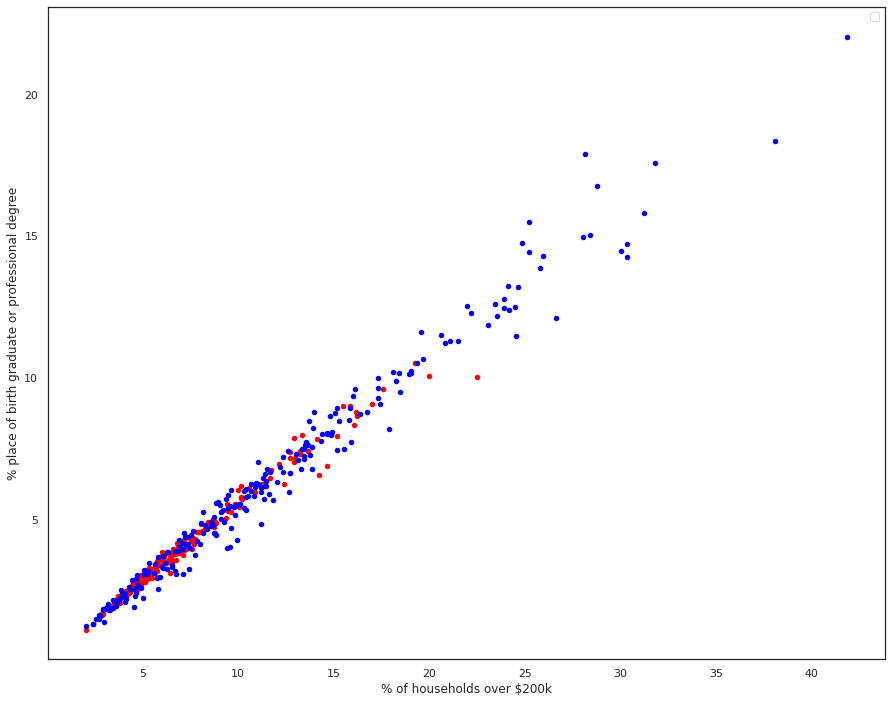

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

R.plot.scatter(x='% of households over $200k', y='% place of birth graduate or professional degree', c='red', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% place of birth graduate or professional degree', c='blue', ax=ax)


plt.legend()
plt.show()

**Pearson's Coefficient - Republicans (Graduate or Professional vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% place of birth graduate or professional degree', '% of households over $200k']]

R_3 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_3 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_3.corr(method="pearson")

,% place of birth graduate or professional degree,% of households over $200k
% place of birth graduate or professional degree,1.000000,0.990413
% of households over $200k,0.990413,1.000000


**Pearson's Coefficient - Democrats (Graduate Degree or Higher vs. Households over $200k)**

In [ ]:
D_3.corr()

,% place of birth graduate or professional degree,% of households over $200k
% place of birth graduate or professional degree,1.000000,0.989277
% of households over $200k,0.989277,1.000000


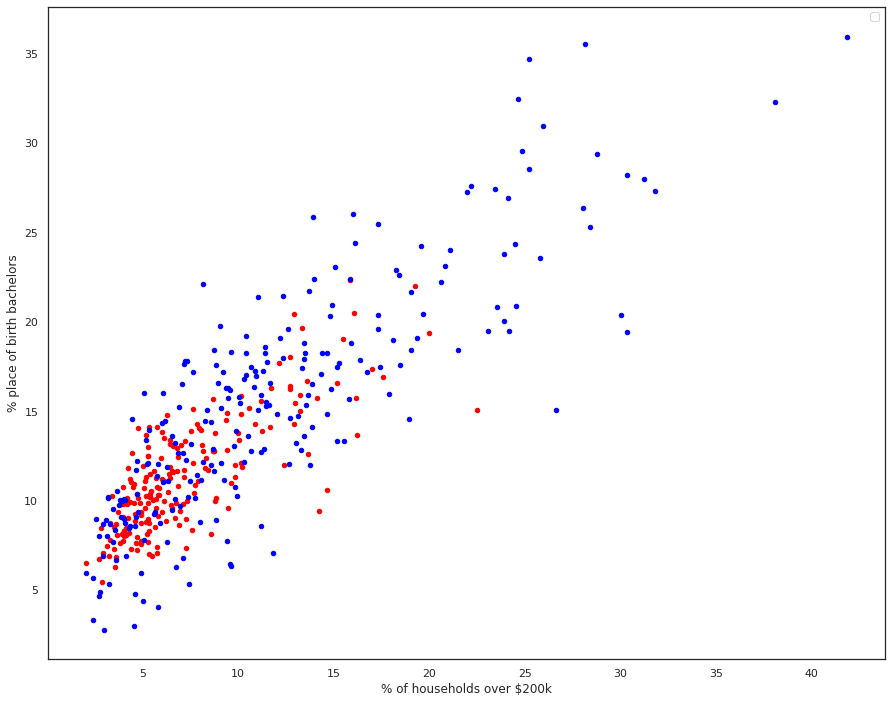

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% place of birth bachelors', c='red', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% place of birth bachelors', c='blue', ax=ax)

plt.legend()
plt.show()

**Pearson's Coefficient - Republicans (Bachelors Degree vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% place of birth bachelors', '% of households over $200k']]

R_4 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_4 = pearson_df.where((merged_df['Party'].str.contains('D'))) 

R_4.corr(method="pearson")

,% place of birth bachelors,% of households over $200k
% place of birth bachelors,1.000000,0.777467
% of households over $200k,0.777467,1.000000


**Pearson's Coefficient - Democrats (Bachelors Degree vs. Households over $200k)**

In [ ]:
D_4.corr(method="pearson")

,% place of birth bachelors,% of households over $200k
% place of birth bachelors,1.000000,0.838163
% of households over $200k,0.838163,1.000000


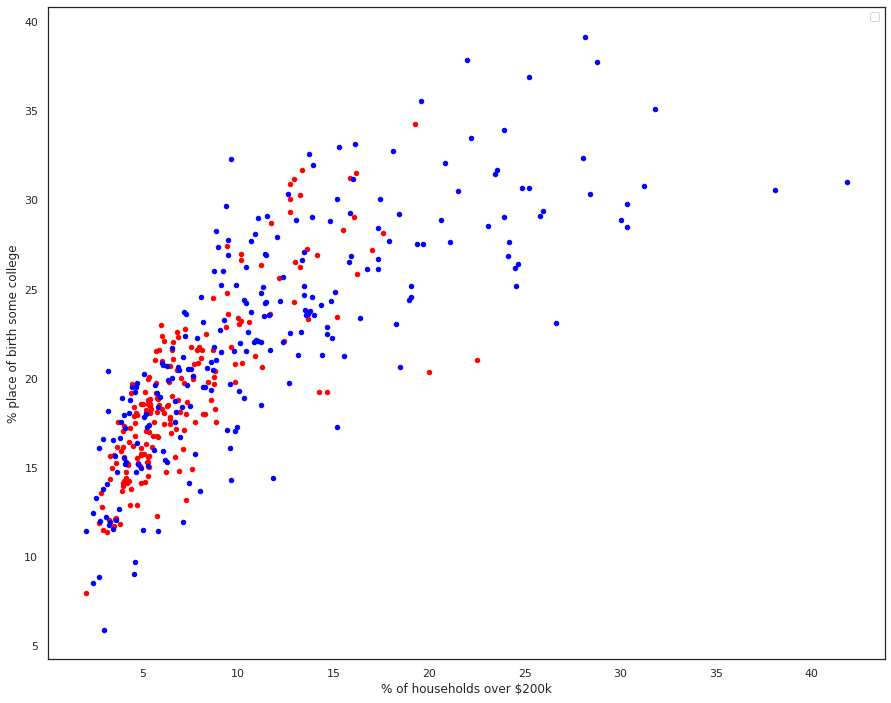

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

R.plot.scatter(x='% of households over $200k', y='% place of birth some college', c='red', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% place of birth some college', c='blue', ax=ax)

plt.legend()
plt.show()


**Pearson's Coefficient - Republicans (Some College vs. Households over $200k)**

In [ ]:
pearson_df = merged_df[['% place of birth some college', '% of households over $200k']]

R_5 = pearson_df.where((merged_df['Party'].str.contains('R')))
D_5 = pearson_df.where((merged_df['Party'].str.contains('D')))

R_5.corr(method="pearson")

,% place of birth some college,% of households over $200k
% place of birth some college,1.000000,0.795145
% of households over $200k,0.795145,1.000000


**Pearson's Coefficient - Democrats (Some College vs. Households over $200k)**

In [ ]:
D_5.corr(method="pearson")

,% place of birth some college,% of households over $200k
% place of birth some college,1.000000,0.772677
% of households over $200k,0.772677,1.000000


# Conclusion

  The correlation matrixes allow us to numerically compare the correlation between income and education in different circumstances - does it differ at different levels of education and does it differ for democrats and republication? Interestingly, at very high levels of education (graduate or professional degree) and lower levels of education (some college), there's a slightly stronger correlation with high income for Republicans than Democrats. However, for populations with a bachelors' degree, Democrats had much stronger correlation with high income than Republications.
  
  Education seems to be highly correlated with income based on our analysis. Moreover, districts where a large proportion (more than 25%) of the population is both educated and affluent, tend to have constituents with liberal political views.

  